In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import sys
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})

In [2]:
NTURN = [65536,65536*2]
mu = 0.04
NU = [0.30345]
TAU = [0.4]
order=1

nCore_y = 4
nCore_z = 4

NL_c = 0.01
NL_L = 1.8

npt=7668

pipe_radius = 0.02*np.sqrt(2.0)

# 1. Preparation

### 1.1 read InputFile and simplify lattice

In [3]:
beam, lattice = impact.readInputFile('test_toymodel.in');
beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
beam.distribution.distribution_type = 'ReadFile'
beam.current = 0.0
beam.n_particles = npt

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

reading ImpactZ input file (test_toymodel.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
for i in range(len(lattice)-1,0,-1):
    if lattice[i].type == 'write_raw_ptcl':
        lattice.pop(i)
        
ElemNL = lattice[1]         
ElemNL.n_sckick = 100
ElemNL.length = NL_L
ElemNL.transverse_scale_c = NL_c
ElemNL.pipe_radius = 0.02*np.sqrt(2)

ElemM = lattice[2]
ElemM.nonlinear_insert_length = NL_L

In [5]:
ElemTBT = impact.getElem('TBT')
ElemTBT.pID_begin = 1
ElemTBT.pID_end = npt
lattice.insert(1,ElemTBT)

OUTPUT = impact.getElem('write_raw_ptcl')
OUTPUT.format_id = 2
lattice.append(OUTPUT)

In [6]:
def normalize(data,alfx,betx):
    data[:,1] = (data[:,0]*alfx/np.sqrt(betx) + data[:,1]*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx/np.sqrt(betx) + data[:,3]*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    
def unnormalize(data,alfx,betx):
    data[:,1] = (-data[:,0]*alfx + data[:,1])*NL_c/np.sqrt(betx)
    data[:,3] = (-data[:,2]*alfx + data[:,3])*NL_c/np.sqrt(betx)
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c

### 1.2. generate particles

In [7]:
testP = 0.0
k=0
q_m = beam.multi_charge.q_m[0]
pTest = []
nx = 100
xmax = 0.98
for x in np.linspace(-xmax,xmax,nx):
    for y in np.linspace(-xmax,xmax,nx):
        if x**2+y**2<=xmax**2 :
            k+=1
            pTest.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k]) 
pTest = np.array(pTest)

In [8]:
def run(tau,nu,mu):
    alfx = np.tan(np.pi*nu)
    betx = NL_L/np.sin(2.0*np.pi*nu)
    pData = copy(pTest)
    unnormalize(pData,alfx,betx)
    impact.writeParticleData(pData, ke, mass, freq)
    
    lattice[0].turns = NTURN[0]
    ElemNL.strength_t = tau
    ElemNL.tune_advance = nu
    ElemM.tune_advance_x = mu
    ElemM.tune_advance_y = mu
    ElemM.nonlinear_insert_tuneAdvance = nu
    ElemTBT.file_id = NTURN[0]
    OUTPUT.file_id = NTURN[0]
    OUTPUT.turn = NTURN[0]
    beam.distribution.distribution_type = 'ReadFile'
    impact.writeInputFile(beam,lattice) 
    impact.run(beam,order=order)
    for nturn in NTURN[:-1]:
        lattice[0].turns = nturn
        ElemTBT.file_id = nturn*2
        OUTPUT.turn = nturn
        OUTPUT.file_id = nturn*2
        beam.distribution.distribution_type = 'ReadFile_binary'
        beam.distribution.file_id = nturn
        impact.writeInputFile(beam,lattice) 
        impact.run(beam,order=order)

In [9]:
def getClosestDiff(ref,arr):
    # ref.shape = nSample
    nMode = len(arr)
    if ref>1.0:
        ref = ref - 1.0
    for i in range(nMode):
        if arr[i]>1.0:
            arr[i]=arr[i]-1.0
    diff = np.abs(ref-arr)
    for i in range(nMode):
        if (diff[i]>0.5):
            diff[i] = 1.0 - diff[i]
    return np.min(diff)


def getData(tau,nu,mu):
    alfx = np.tan(np.pi*nu)
    betx = NL_L/np.sin(2.0*np.pi*nu)
    iTBT = {}
    TBT = {}
    Npt = {}
    
    
    # read TBT data
    for nturn in NTURN:
        iTBT[nturn],TBT[nturn] = impact.readTBT(nturn,ke,mass,freq)
        TBT[nturn] = TBT[nturn][:,:4,:]
        Npt[nturn] = len(iTBT[nturn])

        
    # normalize TBT data
    XF = {}
    YF = {}
    for i in range(len(NTURN)):
        nturn = NTURN[i]
        npt = len(iTBT[nturn])
        XF[nturn]=np.zeros((nturn,npt),dtype=np.complex)
        YF[nturn]=np.zeros((nturn,npt),dtype=np.complex)
        iturn = 0
        for j in range(i+1):
            jturn = NTURN[j]
            itmp = np.in1d(iTBT[jturn],iTBT[nturn])
            tmp = TBT[jturn][:,:,itmp]
            XF[nturn][iturn:jturn] = (tmp[:,0,:] - 1j*(betx*tmp[:,1,:]+alfx*tmp[:,0,:]))/(NL_c*np.sqrt(betx))
            YF[nturn][iturn:jturn] = (tmp[:,2,:] - 1j*(betx*tmp[:,3,:]+alfx*tmp[:,2,:]))/(NL_c*np.sqrt(betx))
            iturn = jturn
    TBT = None
    iTBT = None
    #FD
    tuneXbefore= {}
    tuneYbefore= {}
    Xdiff = {}
    Ydiff = {}
    Adiff = {}
    for nturn in NTURN[:-1]:
        nturn2 = 2*nturn
        npt = len(XF[nturn2][0,:])
        tuneXbefore[nturn] = np.zeros(npt)
        tuneYbefore[nturn] = np.zeros(npt)
        Xdiff[nturn] = np.zeros(npt)
        Ydiff[nturn] = np.zeros(npt)
        Adiff[nturn] = np.zeros(npt)
        for i in range(npt):
            signal = XF[nturn2][:nturn,i] -np.mean(XF[nturn2][:nturn,i])
            tuneXbefore[nturn][i],amp,dummy = impact.util.naff(1,signal,window_id=1)
            signal = XF[nturn2][nturn:,i] -np.mean(XF[nturn2][nturn:,i])
            tune,amp,dummy = impact.util.naff(3,signal,window_id=1)
            Xdiff[nturn][i] = getClosestDiff(tuneXbefore[nturn][i],tune)
            signal = YF[nturn2][:nturn,i] -np.mean(YF[nturn2][:nturn,i])
            tuneYbefore[nturn][i],amp,dummy = impact.util.naff(1,signal,window_id=1)
            signal = YF[nturn2][nturn:,i] -np.mean(YF[nturn2][nturn:,i])
            tune,amp,dummy = impact.util.naff(3,signal,window_id=1)
            Ydiff[nturn][i] = getClosestDiff(tuneYbefore[nturn][i],tune)

        Adiff[nturn] = np.sqrt(Xdiff[nturn]**2 +Ydiff[nturn]**2)
        Adiff[nturn] = np.log10(Adiff[nturn]+1.0e-6)
        Xdiff[nturn] = np.log10(Xdiff[nturn]+1.0e-6)
        Ydiff[nturn] = np.log10(Ydiff[nturn]+1.0e-6)
    
        
    X = {}
    Y = {}
    for n in NTURN[:-1]:
        X[ n]=np.real(XF[2*n][0,:])
        Y[ n]=np.real(YF[2*n][0,:])
    XF={}
    YF={}
    return {'X':X,'Y':Y,'c':Adiff}#,'rawX':XB,'rawY':YB}

In [ ]:
data = {}
for tau in TAU:
    for nu in NU:
        print('<<<< nu='+str(nu)+'.tau='+str(tau)+'.mu='+str(mu)+' >>>>')
        run(tau,nu,mu)
        data['nu='+str(nu)+'.tau='+str(tau)+'.mu='+str(mu)] = getData(tau,nu,mu)

<<<< nu=0.30345.tau=0.4.mu=0.04 >>>>


In [ ]:
import pickle
pickle.dump(data,open('DA.data_longterm.nu='+str(NU[0])+'.tau=0.4.mu='+str(mu)+'.pickle','wb'))

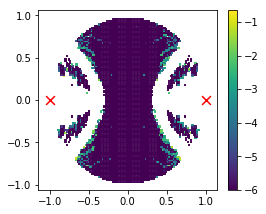

In [14]:
deco = list(data.keys())[0]
n = NTURN[0]
plt.figure(figsize=[4,3.3])
cmap=plt.scatter(data[deco]['X'][n],data[deco]['Y'][n],c=data[deco]['c'][n],s=1.6,marker='s')
plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
plt.colorbar(cmap)

In [ ]:
data